In [4]:
from math import log, exp

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
from scipy.stats import (norm, lognorm, 
                         gamma, percentileofscore)

import seaborn as sns

# Section

- Free
- Full control - not a black box
- fully customizable
- easy export of results (images/Excel

## Subsection

lorem ipsum

[SciPy's](https://www.scipy.org) [*statistical submodule*](https://docs.scipy.org/doc/scipy/reference/stats.html)
[*norm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html), 
[*lognorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html), 
[*beta*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html), 
[*triang*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html), &
[*truncnorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html) continous distributions.

random variates method [*rvs( )*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html)

[*clip( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html) method
[*describe( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html?highlight=describe) method

# Using SciPy to generate random variates from a distribution

`distribution = norm(loc=1, scale=2)`

`distribution.rvs(n)`

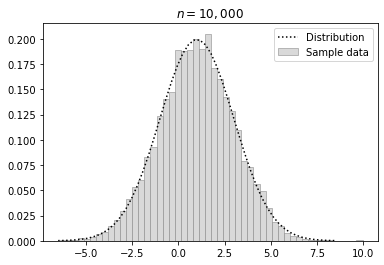

In [19]:
# define distribution
distribution = norm(loc=1, scale=2)

# generate x y data for the ideal distribution
x = np.linspace(-6.5, 8.5)
y = distribution.pdf(x)

# create Pyplot axes for plotting results
fig, ax = plt.subplots()

n = 10_000

# plot a histogram of the random variates
ax.hist(distribution.rvs(int(n)), bins=50, density=True,
        fc='0.85', ec='0.5', lw=0.5,
        label='Sample data')
    
# plot the ideal distribution
ax.plot(x, y, c='k', ls=':', 
        label='Distribution')
    

ax.set_title("$n={:,.0f}$".format(n))
ax.legend()
plt.show()



In [7]:
%%timeit 
distribution.rvs(int(1_000_000))

49.7 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


To make things a little simpler going forward, we can create some functions to instantiate SciPy distribution objects using more user firendly parameters, especially for the log-normal distribution. The two functions below do this taking the *P<sub>90</sub>* and *P<sub>10</sub>* as input parameters.

In [9]:
def norm_dist(p90, p10):
    if p90 > p10:
        p90, p10 = p10, p90
    mean = (p90 + p10) / 2 
    std = (p10 - p90) / (norm.ppf(0.9) - norm.ppf(0.1))
    return norm(loc=mean, scale=std)
    

def lognorm_dist(p90, p10):
    if p90 > p10:
        p90, p10 = p10, p90
    std = log(p10 / p90) / (norm.ppf(0.9) - norm.ppf(0.1))
    mean = (log(p10) - 2**0.5 * std 
            * (gamma.ppf(0.8, a=0.5, scale=1))**0.5)
    return lognorm(s=std, scale=exp(mean))

# Generating random variates for volumetric parameters

We can now 

In [11]:
params = {
    'GRV':      lognorm_dist(p90=10e6, p10=25e6),
    'NTG':      norm_dist(p90=0.6, p10=0.8),
    'Porosity': norm_dist(p90=0.125, p10=0.225),
    'Sw':       norm_dist(p90=0.15, p10=0.45),
    'FVF':      norm_dist(p90=1.1, p10=1.3),
    'RF':       norm_dist(p90=0.15, p10=0.25),
}
realisations = pd.DataFrame([], columns=params)

In [27]:
num_samples = 100_000

for parameter, distr in params.items():
    realisations[parameter] = distr.rvs(num_samples)
    
realisations.describe(percentiles=[0.1, 0.5, 0.9],)

,GRV,NTG,Porosity,Sw,FVF,RF,STOOIP,Resource
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.684777e+07,0.700071,0.175113,0.299733,1.200095,0.199904,7.571290,1.515254
std,6.192056e+06,0.078127,0.039085,0.117200,0.078042,0.039151,3.689749,0.807746
min,3.416049e+06,0.374328,0.003703,-0.224625,0.883863,0.030578,0.736260,0.088545
10%,9.997610e+06,0.600191,0.125161,0.150009,1.100049,0.149780,3.696032,0.686620
50%,1.581997e+07,0.700205,0.175063,0.299755,1.200163,0.199960,6.836347,1.345720
90%,2.495042e+07,0.800458,0.225157,0.449713,1.300139,0.250062,12.361697,2.559564
max,7.279686e+07,1.041537,0.364169,0.887729,1.548159,0.355117,41.972918,9.653981


In [14]:
realisations.Porosity = realisations.Porosity.clip(lower=0.1)
realisations.Sw = realisations.Sw.clip(lower=0.15, upper=0.70)

# Volumetric calculations and reporting

In [15]:
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

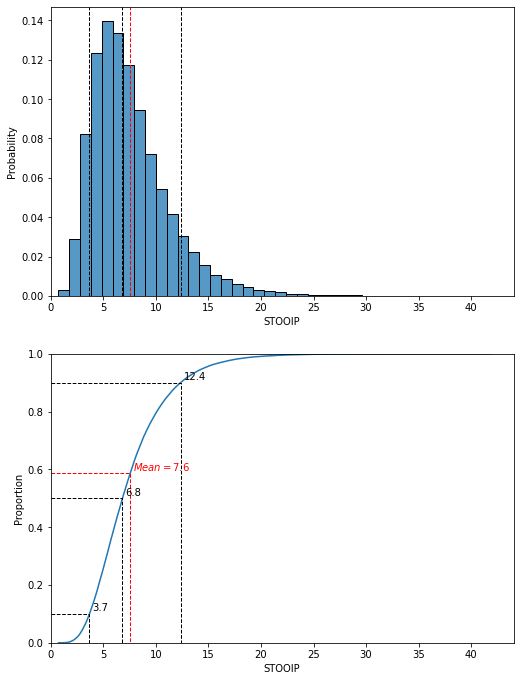

In [51]:
fig, ax = plt.subplots(nrows=2, figsize=(8.3, 11.7))

# display histogram of distribution in first subplot
sns.histplot(realisations.STOOIP, ax=ax[0], stat='probability', bins=40)
# display empirical cumulative distribution function
# in second subplot
sns.ecdfplot(realisations.STOOIP, ax=ax[1])

# display key percentiles and mean on cumulative plot
ax[0].set_xlim(left=0)
ax[0].set_ylim(ax[0].get_ylim()) # freeze ylim
ax[1].set_xlim(ax[0].get_xlim())
y_max = ax[0].get_ylim()[1]
ls = {'c':'k', 'ls': '--', 'lw': '1'}
for p in [0.1, 0.5, 0.9]:
    q = realisations.STOOIP.quantile(p)
    ax[0].plot([q] * 2, [0, y_max], **ls)
    ax[1].plot([0] + [q] * 2,
               [p] * 2 + [0],
               **ls)
    ax[1].annotate('{:.1f}'.format(q), 
                   (q, p),
                   xytext=(3, 3),
                   textcoords='offset pixels',
                   c='k')
    
ls_mean = {'c':'r', 'ls': '--', 'lw': '1'}
mean = realisations.STOOIP.mean()
Pmean = percentileofscore(realisations.STOOIP,
                          mean, kind='weak') / 100
ax[0].plot([mean] * 2, [0, y_max],
           **ls_mean)
ax[1].plot([0] + [mean] * 2, [Pmean] * 2 + [0],
           **ls_mean)
ax[1].annotate('$Mean={:.1f}$'.format(mean), 
               (mean, Pmean),
               xytext=(3, 3),
               textcoords='offset pixels',
               c='r')

plt.show()

In [26]:
summary = realisations.describe(percentiles=[0.1, 0.5, 0.9],).T \
    .iloc[:,[3,4,5,6,7,1]]
summary.columns = ['Min', 'P90', 'P50', 'P10', 'Max', 'Mean']
summary

,Min,P90,P50,P10,Max,Mean
GRV,2.867790e+06,9.967899e+06,1.579696e+07,2.503827e+07,7.962521e+07,1.685423e+07
NTG,3.521007e-01,5.997839e-01,6.994282e-01,7.998220e-01,1.027485e+00,6.996092e-01
Porosity,7.827064e-03,1.250285e-01,1.750510e-01,2.244209e-01,3.576259e-01,1.748908e-01
Sw,-2.353030e-01,1.509306e-01,3.002974e-01,4.501368e-01,7.712817e-01,3.003369e-01
FVF,8.760428e-01,1.100355e+00,1.200428e+00,1.299980e+00,1.613135e+00,1.200105e+00
RF,3.494080e-02,1.500525e-01,1.999224e-01,2.499722e-01,3.644971e-01,1.999013e-01
STOOIP,7.362605e-01,3.696032e+00,6.836347e+00,1.236170e+01,4.197292e+01,7.571290e+00
Resource,8.854514e-02,6.866196e-01,1.345720e+00,2.559564e+00,9.653981e+00,1.515254e+00


In [40]:
ax[0].get_ylim()

(0.0, 0.146937)

export to Excel

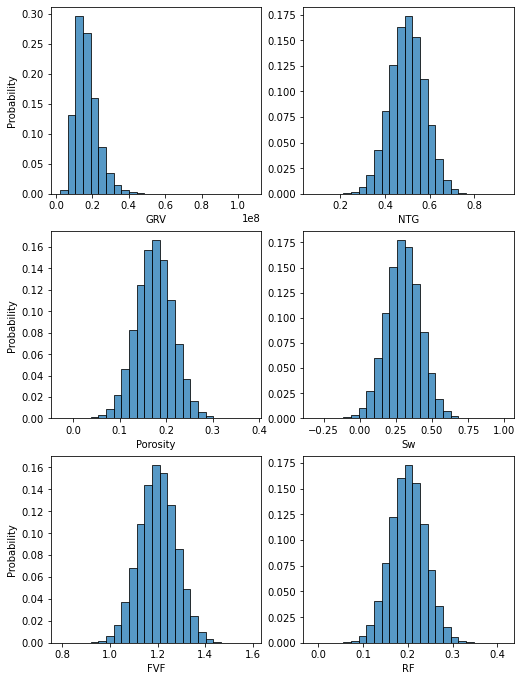

In [64]:
num_samples = 20_000_000


realisations = pd.DataFrame([], columns=params)

for k, v in params.items():
    realisations[k] = v.rvs(num_samples)

In [65]:
realisations.Porosity = realisations.Porosity.clip(lower=0.1)
realisations.Sw = realisations.Sw.clip(lower=0.15)
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

In [115]:
summary_stats = realisations.Resource.groupby(by=np.arange(200). \
                                repeat(100_000)). \
                                quantile([0.1, 0.5, 0.9]). \
                                unstack()
summary_stats['Mean'] = realisations.Resource.groupby(by=np.arange(200). \
                                repeat(100_000)). \
                                mean()
summary_stats = summary_stats / summary_stats.mean()

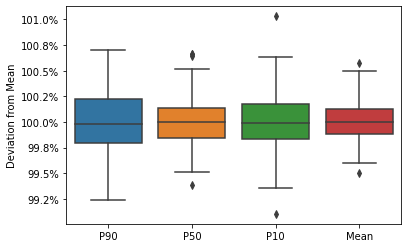

In [116]:
fig, ax = plt.subplots()
summary_stats.columns = ['P90', 'P50', 'P10', 'Mean']
sns.boxplot(data=summary_stats.melt(value_name='Deviation from Mean'), 
            x='variable', 
            y='Deviation from Mean', 
            ax=ax)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1%}'))
ax.set_xlabel(None)
plt.show()